Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.


# Low-Priority Compute

_**A tutorial on training models using low-priority compute**_

## Contents
1. [Introduction](#Introduction)
1. [MNIST Dataset](#MNIST-Dataset)
1. [Setup](#Setup)
1. [Model Checkpointing](#Model-Checkpointing)
1. [Create a Low-Priority Cluster](#Create-a-Low-Priority-Cluster)
1. [Experiment](#Experiment)
1. [Handling Metrics](#Handling-Metrics)

## Introduction

This notebook discusses training models using [low-priority compute](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-manage-optimize-cost#low-pri-vm). Training on low-priority compute can cost much less than on dedicated compute.

When creating a compute cluster, its priority must be specified. The priority can either be _dedicated_ (default) or _low priority_. (See [this API doc](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.compute.amlcompute.amlcomputeprovisioningconfiguration?view=azure-ml-py) for details.)

A job using dedicated compute is granted uninterrupted access to a VM. In contrast, a job using low-priority compute is not. A job using low-priority compute is only granted temporary access to a VM. The hardware used by low-priority jobs may be ceded to / preempted by higher priority jobs, depending on region-wide availability of hardware and other factors.

When a job using low-priority compute is preempted, that job must stop running. The job waits for low-priority compute to become available again in the region. Once compute again becomes available, something notable happens: the run restarts "from scratch" on the new compute. In other words, previous state on the compute is lost, and the submitted Python script is re-invoked fresh on the new compute.

This means that, without special handling, every time a training run is preempted and restarted, the model will start training again from scratch. For instance, when training a DNN model, every time the run is preempted and restarted, the run will start training from epoch 0 again. For this reason, we need some special handling in the training script to save state between preemptions, so previous work can be reused after restarts.

## MNIST Dataset

All models will be trained on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), which consists of images of handwritten digits.

## Setup

Let's import some dependencies we'll need:

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

from azureml.core import Experiment, Workspace
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from helper import launch_run

Let's initialize the workspace and experiment.

Make sure you have the run [configuration notebook](https://github.com/Azure/azureml-examples/blob/main/python-sdk/experimental/automl-model-testing/configuration.ipynb) to create a workspace and save its corresponding config file before running this notebook.

In [5]:
# Initialize the workspace
workspace = Workspace.from_config()

# Choose a name for experiment
experiment_name = "low-priority-compute"

# Initialize the experiment
experiment = Experiment(workspace, experiment_name)

output = {}
output["Subscription ID"] = workspace.subscription_id
output["Workspace"] = workspace.name
output["Resource Group"] = workspace.resource_group
output["Location"] = workspace.location
output["Experiment Name"] = experiment.name
pd.set_option("display.max_colwidth", -1)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T

,
Subscription ID,381b38e9-9840-4719-a5a0-61d9585e1e91
Workspace,daholstewseus
Resource Group,daholsterg
Location,eastus
Experiment Name,low-priority-compute


## Model Checkpointing

### How to Checkpoint

When training a DNN on low-priority compute, you can checkpoint the training state periodically.

In the [training script](training_script/training_script.py) used with this notebook, we checkpoint the state after each epoch:

```python
for epoch in range(...):
    ...
    train_epoch(...)

    save_checkpoint(model, optimizer, epoch)
    ...
```

`save_checkpoint` is implemented as:
```python

MODEL_CHECKPOINT_PATH = 'model_checkpoints/checkpoint.pt'

def save_checkpoint(model, optimizer, epoch):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, MODEL_CHECKPOINT_PATH)
    ...
```

This code saves a copy of of the relevant information to `MODEL_CHECKPOINT_PATH`. This info includes the latest model weights and optimizer state.


### Uploading the Checkpoint to the Cloud

Saving to `CHECKPOINT_MODEL_PATH` on the compute triggers an automatic upload of the model to blob storage. This is because when we launch a script run in [helper.py](helper.py) , we pass an `OutputFileDatasetConfig`:

```python
output_dataset_config = OutputFileDatasetConfig('model_checkpoints',
                                                destination=...,
                                                source='model_checkpoints/')
...
ScriptRunConfig(..., arguments=[output_dataset_config, ...], ...)
```

Under the hood, this mounts the blob folder represented by `destination` to the local `model_checkpoints` directory on the compute. In other words, whenever a file is written to the `model_checkpoints` directory on the compute, it will automatically be uploaded to `destination` relative path in blob storage. Also, any file available in the `destination` blob storage directory is available in the `model_checkpoints` directory on the compute. Note that if the `destination` parameter is blank, the default destination in blob storage is `/dataset/{run_id}/model_checkpoints/`. See the documentation on [OutputFileDatasetConfig](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.output_dataset_config.outputfiledatasetconfig?view=azure-ml-py) for more info.


### Loading Checkpoints at the Start of a Run

Finally, at the start of our training script, we have:

```python
if checkpoint_file_exists:
    ...
    model, optimizer, starting_epoch = load_checkpoint()
    starting_epoch += 1
else:
    model = init_model()
    optimizer = init_optimizer(model)
    starting_epoch = 0
```

This means that, when the script starts, by default, it will check to see if a checkpoint already exists in storage. If a saved checkpoint exists, the script will load the saved state, and continue from there. Otherwise, the script will start training a new model from scratch.

## Create a Low-Priority Cluster

Define a function to create a compute cluster:

In [1]:
def create_compute_cluster(workspace, name, vm_priority='dedicated'):
    """Create a compute cluster."""
    try:
        compute_target = ComputeTarget(workspace=workspace, name=name)
        print(f'Found existing cluster for {name} -- using it')
        return compute_target
    except ComputeTargetException:
        compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6', vm_priority=vm_priority)
        compute_target = ComputeTarget.create(workspace, name, compute_config)
        print(f'Creating cluster {name}')
        compute_target.wait_for_completion(show_output=True)
        return compute_target

Invoke the function to create a low-priority compute cluster:

In [ ]:
low_pri_compute = create_compute_cluster(workspace=workspace, name='low-pri-cluster')

## Experiment

### Introduction

Let's do an experiment simulating the preemption and restart that would happen on low-priority compute.

Preemption of low-priority compute isn't something that we can demonstrate directly. Azure decides to preempt compute based on region-wide availability of hardware and other factors. However, we can try to simulate preemption using dedicated compute.

### Setup

Create a high priority compute cluster:

In [ ]:
compute = create_compute_cluster(
    workspace=workspace
    name='low-pri-compute-sample-cluster',
)

### First Run
Launch a run for 2 epochs on dedicated compute.

In [24]:
run1 = launch_run(
    experiment=experiment,
    compute_target=compute,
    num_epochs=2)

run1

Found existing cluster for low-pri-compute-sample-cluster -- using it


Experiment,Id,Type,Status,Details Page,Docs Page
low-priority-compute,low-priority-compute_1647278955_18a03398,azureml.scriptrun,Queued,Link to Azure Machine Learning studio,Link to Documentation


In [25]:
run1.wait_for_completion()

{'runId': 'low-priority-compute_1647278955_18a03398',
 'target': 'low-pri-compute-sample-cluster',
 'status': 'Completed',
 'startTimeUtc': '2022-03-14T17:29:32.033112Z',
 'endTimeUtc': '2022-03-14T17:30:51.468372Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '886ffd85-55b8-4ea5-8c73-9ad7ad5c635e',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json',
  'azureml.git.repository_uri': 'https://github.com/daholste/azureml-examples',
  'mlflow.source.git.repoURL': 'https://github.com/daholste/azureml-examples',
  'azureml.git.branch': 'daholste/distributed_image_notebook',
  'mlflow.source.git.branch': 'daholste/distributed_image_notebook',
  'azureml.git.commit': '0d93279fea453e59e52672213e603322e87f2db2',
  'mlflow.source.git.commit': '0d93279fea453e59e52672213e603322e87f2db2',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'outputDatasets': [{'identifier': {'saved

Checking metrics:

In [26]:
run1_metrics = run1.get_metrics()
run1_metrics['training_epoch']

{'training_epoch': [0, 1]}

We can see that the run only trained epochs 0 and 1.

### Second Run

Let's start a second run that continues where the first run left off.

The first run should have saved a checkpoint in the `/dataset/{run1.id}/model_checkpoints/` directory in the default blob storage account. When we start second run, let's overrode the checkpoint path in storage from its default of `/dataset/{run2.id}/model_checkpoints/` to `/dataset/{run1.id}/model_checkpoints/`. The second run should continue training the model from where the first run left off. Let's see if that's the case.

Kicking off the second run:

In [15]:
run2 = launch_run(
    experiment=experiment,
    compute_target=compute,
    num_epochs=4,
    output_dataset_storage_path=f'/dataset/{run1.id}/model_checkpoints/')

run2

{'runId': 'low-priority-compute_1647277919_c3ac723c',
 'target': 'low-pri-compute-sample-cluster',
 'status': 'Finalizing',
 'startTimeUtc': '2022-03-14T17:12:07.505819Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '886ffd85-55b8-4ea5-8c73-9ad7ad5c635e',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json',
  'azureml.git.repository_uri': 'https://github.com/daholste/azureml-examples',
  'mlflow.source.git.repoURL': 'https://github.com/daholste/azureml-examples',
  'azureml.git.branch': 'daholste/distributed_image_notebook',
  'mlflow.source.git.branch': 'daholste/distributed_image_notebook',
  'azureml.git.commit': '0d93279fea453e59e52672213e603322e87f2db2',
  'mlflow.source.git.commit': '0d93279fea453e59e52672213e603322e87f2db2',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'outputDatasets': [{'identifier': {'savedId': '1f84cf55-cb2a-42c4-bc62-1a3e3e2a019c'},

In [ ]:
run2.wait_for_completion()

Checking the metrics:

In [20]:
run2_metrics = run2.get_metrics()
run2_metrics['training_epoch']

{'training_epoch': [2, 3]}

We see that, as expected, the second run trained 2 epochs, and it picked up where the first run left off.

### Validation Accuracy

We can also plot the model's accuracy on the validation set after each epoch:

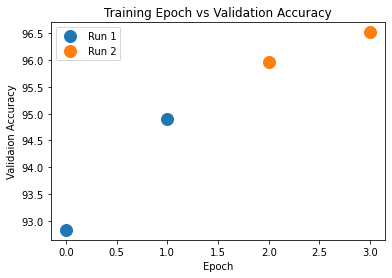

In [43]:
plt.plot(run1_metrics['training_epoch'], run1_metrics['validation_accuracy'], marker='o', linestyle='', ms=12, label='Run 1')
plt.plot(run2_metrics['training_epoch'], run2_metrics['validation_accuracy'], marker='o', linestyle='', ms=12, label='Run 2')
plt.legend()
plt.title('Epoch vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validaion Accuracy')
plt.show()

From the chart above, we can see that the model's accuracy on the validation set improved with each epoch.

## Handling Metrics

When a preempted job is resumed, metrics from previous runs are still present. This is something to keep in mind.

You probably also want to ensure all metrics are flushed (a.k.a. sent from local compute to the metrics servers) around the same time that the model checkpoint is saved. This reduces the likelihood of a race condition where the checkpoint is saved and the run is preempted, but recent metrics for the run haven't yet been flushed and hence are lost.

In the training script, you can see that we flush metrics right before saving the checkpoint:

```python
run.flush()
save_checkpoint(model, optimizer, epoch)
```